In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install pytorch-tabnet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.3 MB/s eta 0:00:00


In [3]:
!pip install rtdl_revisiting_models

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from rtdl_revisiting_models import FTTransformer  # Import benar versi terbaru
import joblib
import json
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [5]:
DATA_PATH = "/content/drive/MyDrive/SEM 7/ML/UAP/synthetic_disaster_events_2025.csv"
SAVE_PATH = "/content/drive/MyDrive/SEM 7/ML/UAP/"
os.makedirs(SAVE_PATH, exist_ok=True)

# Load CSV asli
df = pd.read_csv(DATA_PATH)

# Buat copy untuk training, drop kolom yang tidak dipakai dalam model
# is_major_disaster tetap ada di df asli (untuk input form/batch nanti), tapi diabaikan di training
df_train = df.drop(columns=["event_id", "date", "is_major_disaster"])

In [6]:
def classify_disaster(row):
    score = 0
    if row["severity_level"] >= 7:
        score += 2
    elif row["severity_level"] >= 4:
        score += 1
    if row["affected_population"] >= 50000:
        score += 2
    elif row["affected_population"] >= 10000:
        score += 1
    if row["estimated_economic_loss_usd"] >= 5_000_000:
        score += 2
    elif row["estimated_economic_loss_usd"] >= 1_000_000:
        score += 1
    if row["infrastructure_damage_index"] >= 0.6:
        score += 2
    elif row["infrastructure_damage_index"] >= 0.3:
        score += 1
    if score >= 6:
        return 2  # Severe
    elif score >= 3:
        return 1  # Moderate
    else:
        return 0  # Minor

df_train["disaster_severity_class"] = df_train.apply(classify_disaster, axis=1)

In [7]:
cat_cols = ["disaster_type", "location", "aid_provided"]
num_cols = [c for c in df_train.columns if c not in cat_cols + ["disaster_severity_class"]]

# Label Encoding untuk kategorikal
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    label_encoders[col] = le

# Pisah X dan y
X = df_train.drop(columns=["disaster_severity_class"])
y = df_train["disaster_severity_class"]

# Scaling numerik
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

# Simpan scaler dan encoder untuk inference
joblib.dump(scaler, SAVE_PATH + "scaler.pkl")
joblib.dump(label_encoders, SAVE_PATH + "label_encoders.pkl")

Train: (14000, 10)
Val: (3000, 10)
Test: (3000, 10)


['/content/drive/MyDrive/SEM 7/ML/UAP/label_encoders.pkl']

In [8]:
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

mlp = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

mlp.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history_mlp = mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.7041 - loss: 0.6329 - val_accuracy: 0.8890 - val_loss: 0.2630
Epoch 2/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8707 - loss: 0.2919 - val_accuracy: 0.9000 - val_loss: 0.2379
Epoch 3/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8915 - loss: 0.2527 - val_accuracy: 0.9123 - val_loss: 0.2166
Epoch 4/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8954 - loss: 0.2464 - val_accuracy: 0.9070 - val_loss: 0.2154
Epoch 5/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8984 - loss: 0.2320 - val_accuracy: 0.9140 - val_loss: 0.2033
Epoch 6/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9034 - loss: 0.2152 - val_accuracy: 0.9150 - val_loss: 0.2011
Epoch 7/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9079 - loss: 0.2143 - val_accuracy: 0.9207 - val_loss: 0.1962
Epoch 8/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9061 - loss: 0.2084 - val_accuracy: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MLP Classification Report:
              precision    recall  f1-score   support

       Minor       0.97      0.94      0.95       587
    Moderate       0.95      0.96      0.96      1205
      Severe       0.98      0.98      0.98      1208

    accuracy                           0.97      3000
   macro avg       0.97      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



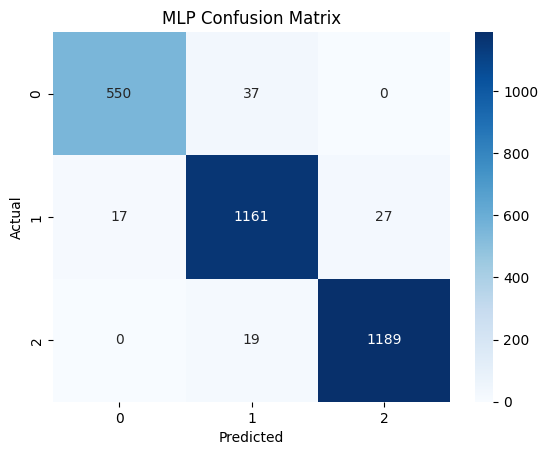

In [9]:
# Evaluasi
class_names = ["Minor", "Moderate", "Severe"]
y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=class_names))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt="d", cmap="Blues")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


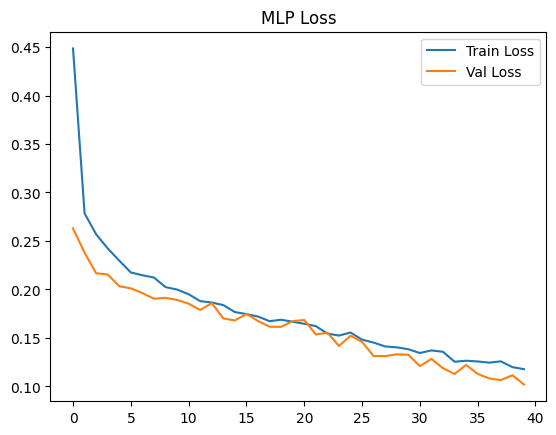

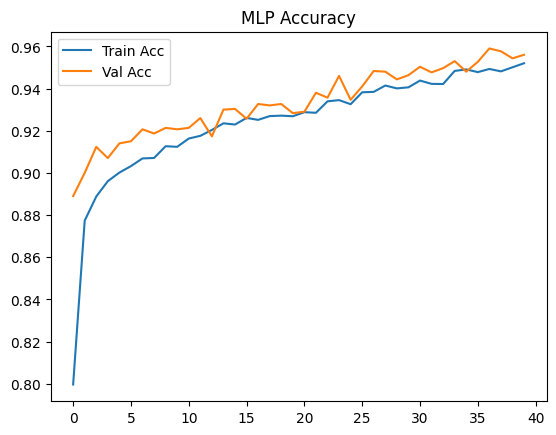

In [10]:
# Plot Loss & Accuracy
plt.plot(history_mlp.history["loss"], label="Train Loss")
plt.plot(history_mlp.history["val_loss"], label="Val Loss")
plt.title("MLP Loss")
plt.legend()
plt.show()

plt.plot(history_mlp.history["accuracy"], label="Train Acc")
plt.plot(history_mlp.history["val_accuracy"], label="Val Acc")
plt.title("MLP Accuracy")
plt.legend()
plt.show()

mlp.save(SAVE_PATH + "mlp_disaster_model.keras")

In [11]:
tabnet = TabNetClassifier(
    n_d=16, n_a=16, n_steps=5, gamma=1.5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    verbose=10
)

tabnet.fit(
    X_train.values, y_train.values,
    eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy", "logloss"],
    max_epochs=200,
    patience=30,
    batch_size=1024,
    virtual_batch_size=128
)

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.70118 | train_accuracy: 0.79664 | train_logloss: 0.5557  | valid_accuracy: 0.786   | valid_logloss: 0.55352 |  0:00:03s
epoch 10 | loss: 0.1778  | train_accuracy: 0.93864 | train_logloss: 0.14624 | valid_accuracy: 0.936   | valid_logloss: 0.16064 |  0:00:16s
epoch 20 | loss: 0.11908 | train_accuracy: 0.96421 | train_logloss: 0.09914 | valid_accuracy: 0.959   | valid_logloss: 0.1085  |  0:00:28s
epoch 30 | loss: 0.09508 | train_accuracy: 0.97393 | train_logloss: 0.06619 | valid_accuracy: 0.97533 | valid_logloss: 0.07198 |  0:00:42s
epoch 40 | loss: 0.12555 | train_accuracy: 0.97343 | train_logloss: 0.07859 | valid_accuracy: 0.96933 | valid_logloss: 0.08852 |  0:00:54s
epoch 50 | loss: 0.10312 | train_accuracy: 0.97371 | train_logloss: 0.06864 | valid_accuracy: 0.97333 | valid_logloss: 0.07567 |  0:01:07s
epoch 60 | loss: 0.08424 | train_accuracy: 0.97964 | train_logloss: 0.05679 | valid_accuracy: 0.975   | valid_logloss: 0.06842 |  0:01:29s
epoch 70 | loss: 0.08439 | 

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [12]:
# Evaluasi TabNet
y_pred_tabnet = tabnet.predict(X_test.values)
print("TabNet Classification Report:")
print(classification_report(y_test, y_pred_tabnet, target_names=class_names))

TabNet Classification Report:
              precision    recall  f1-score   support

       Minor       1.00      0.98      0.99       587
    Moderate       0.98      1.00      0.99      1205
      Severe       1.00      1.00      1.00      1208

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



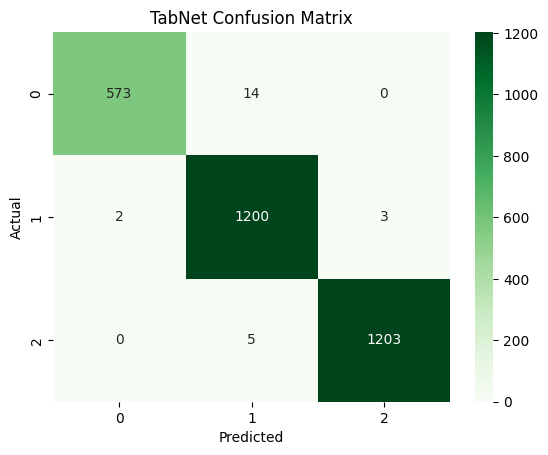

In [13]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_tabnet), annot=True, fmt="d", cmap="Greens")
plt.title("TabNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


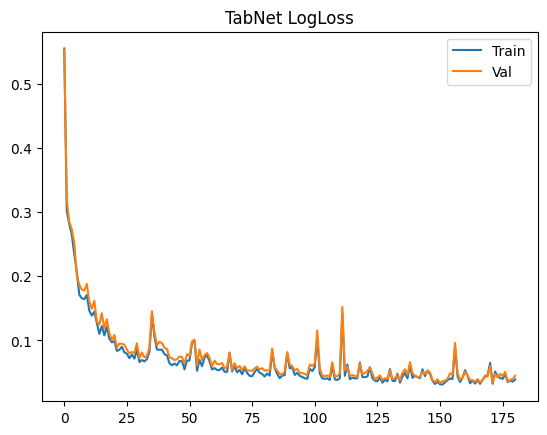

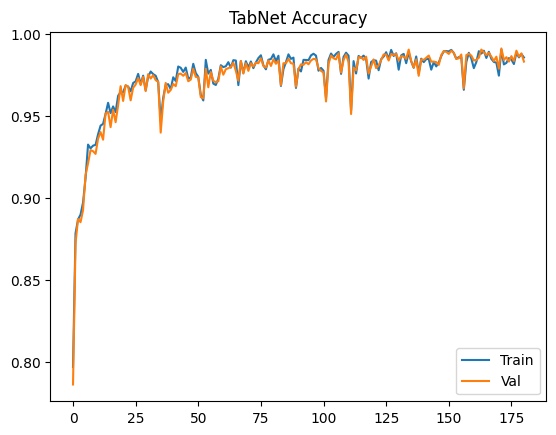

Successfully saved model at /content/drive/MyDrive/SEM 7/ML/UAP/tabnet_disaster_model.zip


'/content/drive/MyDrive/SEM 7/ML/UAP/tabnet_disaster_model.zip'

In [14]:
# Plot LogLoss & Accuracy
plt.plot(tabnet.history["train_logloss"], label="Train")
plt.plot(tabnet.history["valid_logloss"], label="Val")
plt.title("TabNet LogLoss")
plt.legend()
plt.show()

plt.plot(tabnet.history["train_accuracy"], label="Train")
plt.plot(tabnet.history["valid_accuracy"], label="Val")
plt.title("TabNet Accuracy")
plt.legend()
plt.show()

tabnet.save_model(SAVE_PATH + "tabnet_disaster_model")

In [15]:
# =====================================================
# DATA PREPARATION (NUM FIRST, CAT SECOND)
# =====================================================
X_train_num = X_train[num_cols].values.astype("float32")
X_val_num   = X_val[num_cols].values.astype("float32")
X_test_num  = X_test[num_cols].values.astype("float32")

X_train_cat = X_train[cat_cols].values.astype("int64")
X_val_cat   = X_val[cat_cols].values.astype("int64")
X_test_cat  = X_test[cat_cols].values.astype("int64")

y_train_t = torch.LongTensor(y_train.values)
y_val_t   = torch.LongTensor(y_val.values)
y_test_t  = torch.LongTensor(y_test.values)


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
# =====================================================
# CATEGORICAL CARDINALITIES
# =====================================================
cat_cardinalities = [df_train[col].nunique() for col in cat_cols]
num_classes = y_train.nunique()

print("Num classes:", num_classes)
print("Num numerical:", len(num_cols))
print("Num categorical:", len(cat_cols))

# =====================================================
# DATASET & DATALOADER
# =====================================================
batch_size = 512

train_loader = DataLoader(
    TensorDataset(
        torch.FloatTensor(X_train_num),
        torch.LongTensor(X_train_cat),
        y_train_t
    ),
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(
        torch.FloatTensor(X_val_num),
        torch.LongTensor(X_val_cat),
        y_val_t
    ),
    batch_size=batch_size
)

test_loader = DataLoader(
    TensorDataset(
        torch.FloatTensor(X_test_num),
        torch.LongTensor(X_test_cat),
        y_test_t
    ),
    batch_size=batch_size
)

# =====================================================
# FT-TRANSFORMER MODEL (VERSI YANG PAS)
# =====================================================
ft_model = FTTransformer(
    n_cont_features=len(num_cols),
    cat_cardinalities=cat_cardinalities,
    d_block=32,
    n_blocks=4,
    attention_n_heads=8,
    attention_dropout=0.1,
    ffn_d_hidden_multiplier=4 / 3,
    ffn_dropout=0.1,
    residual_dropout=0.1,
    d_out=num_classes
).to(device)

print(ft_model)

# =====================================================
# OPTIMIZER & LOSS
# =====================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(ft_model.parameters(), lr=1e-4, weight_decay=1e-5)

# =====================================================
# TRAINING LOOP
# =====================================================
epochs = 100
patience = 15
wait = 0
best_val_acc = 0
best_state = None

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nTraining FT-Transformer...\n")

for epoch in range(epochs):
    # ---------- TRAIN ----------
    ft_model.train()
    correct = total = train_loss = 0

    for x_num, x_cat, y in train_loader:
        x_num = x_num.to(device)
        x_cat = x_cat.to(device)
        y     = y.to(device)

        optimizer.zero_grad()
        outputs = ft_model(x_num, x_cat)   # 🔥 URUTAN BENAR
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = outputs.max(1)
        total += y.size(0)
        correct += preds.eq(y).sum().item()

    train_acc = correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accs.append(train_acc)

    # ---------- VALIDATION ----------
    ft_model.eval()
    val_correct = val_total = val_loss = 0

    with torch.no_grad():
        for x_num, x_cat, y in val_loader:
            x_num = x_num.to(device)
            x_cat = x_cat.to(device)
            y     = y.to(device)

            outputs = ft_model(x_num, x_cat)
            loss = criterion(outputs, y)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_total += y.size(0)
            val_correct += preds.eq(y).sum().item()

    val_acc = val_correct / val_total
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_acc)

    print(
        f"Epoch {epoch+1:03d} | "
        f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = ft_model.state_dict()
        wait = 0
        print("   → Best model updated!")
    else:
        wait += 1
        if wait >= patience:
            print("\nEarly stopping!")
            break

# =====================================================
# LOAD BEST MODEL
# =====================================================
ft_model.load_state_dict(best_state)
print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")

Num classes: 3
Num numerical: 7
Num categorical: 3
FTTransformer(
  (cls_embedding): _CLSEmbedding()
  (cont_embeddings): LinearEmbeddings()
  (cat_embeddings): CategoricalEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(7, 32)
      (1): Embedding(8, 32)
      (2): Embedding(2, 32)
    )
  )
  (backbone): FTTransformerBackbone(
    (blocks): ModuleList(
      (0): ModuleDict(
        (attention): MultiheadAttention(
          (W_q): Linear(in_features=32, out_features=32, bias=True)
          (W_k): Linear(in_features=32, out_features=32, bias=True)
          (W_v): Linear(in_features=32, out_features=32, bias=True)
          (W_out): Linear(in_features=32, out_features=32, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (attention_residual_dropout): Dropout(p=0.1, inplace=False)
        (ffn_normalization): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (linear1): Linear(in_features=32, out_featu


FT-Transformer Classification Report:
              precision    recall  f1-score   support

       Minor       0.99      0.99      0.99       587
    Moderate       1.00      0.99      0.99      1205
      Severe       0.99      1.00      1.00      1208

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



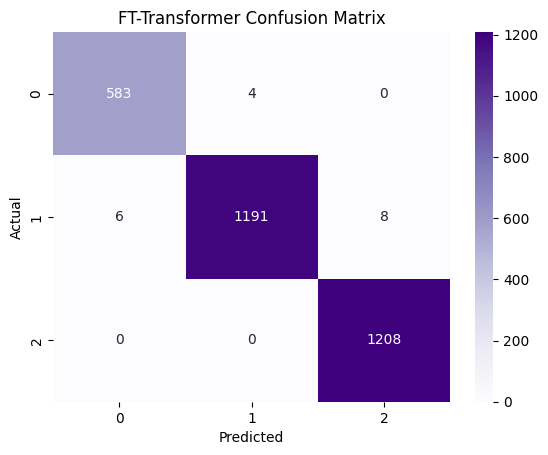

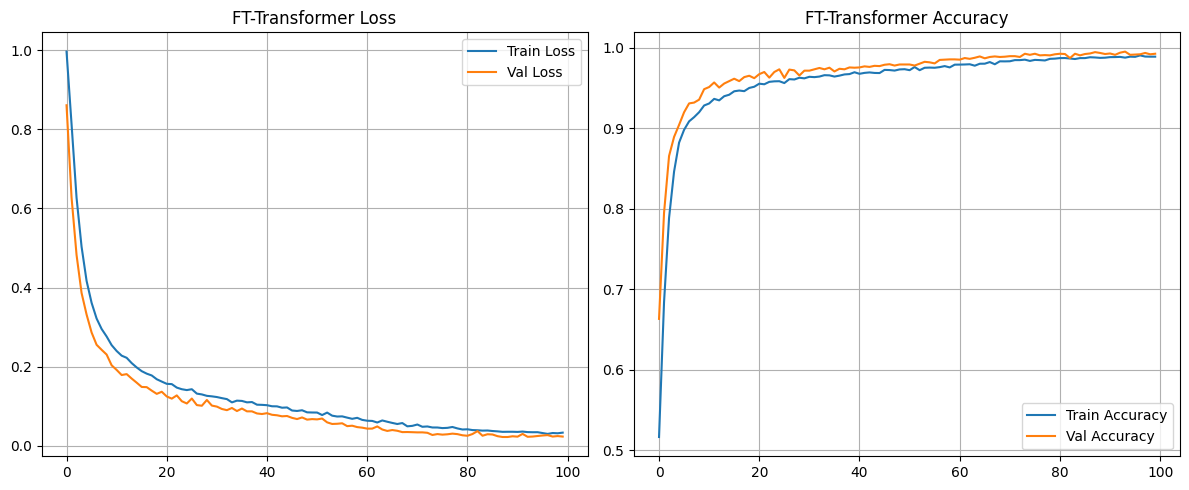


FT-Transformer training & evaluation DONE ✅


In [19]:
# =====================================================
# TEST EVALUATION
# =====================================================
ft_model.eval()
y_pred_ft = []

with torch.no_grad():
    for x_num, x_cat, _ in test_loader:
        x_num = x_num.to(device)
        x_cat = x_cat.to(device)
        outputs = ft_model(x_num, x_cat)
        _, preds = outputs.max(1)
        y_pred_ft.extend(preds.cpu().numpy())

# =====================================================
# CLASSIFICATION REPORT
# =====================================================
print("\nFT-Transformer Classification Report:")
print(classification_report(y_test, y_pred_ft, target_names=class_names))

# =====================================================
# CONFUSION MATRIX
# =====================================================
sns.heatmap(
    confusion_matrix(y_test, y_pred_ft),
    annot=True,
    fmt="d",
    cmap="Purples"
)
plt.title("FT-Transformer Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =====================================================
# LOSS & ACCURACY PLOT
# =====================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("FT-Transformer Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("FT-Transformer Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# =====================================================
# SAVE MODEL
# =====================================================
torch.save(ft_model.state_dict(), SAVE_PATH + "ft_transformer_disaster_model.pth")

print("\nFT-Transformer training & evaluation DONE ✅")

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik untuk masing-masing model (macro average agar adil untuk multiclass)

# MLP
acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp, average='macro')
rec_mlp = recall_score(y_test, y_pred_mlp, average='macro')
f1_mlp = f1_score(y_test, y_pred_mlp, average='macro')

# TabNet
acc_tabnet = accuracy_score(y_test, y_pred_tabnet)
prec_tabnet = precision_score(y_test, y_pred_tabnet, average='macro')
rec_tabnet = recall_score(y_test, y_pred_tabnet, average='macro')
f1_tabnet = f1_score(y_test, y_pred_tabnet, average='macro')

# FT-Transformer
acc_ft = accuracy_score(y_test, y_pred_ft)
prec_ft = precision_score(y_test, y_pred_ft, average='macro')
rec_ft = recall_score(y_test, y_pred_ft, average='macro')
f1_ft = f1_score(y_test, y_pred_ft, average='macro')

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({
    'Model': ['MLP', 'TabNet', 'FT-Transformer'],
    'Accuracy': [acc_mlp, acc_tabnet, acc_ft],
    'Precision (macro)': [prec_mlp, prec_tabnet, prec_ft],
    'Recall (macro)': [rec_mlp, rec_tabnet, rec_ft],
    'F1-Score (macro)': [f1_mlp, f1_tabnet, f1_ft]
})

# Format angka menjadi persen dengan 2 desimal
comparison_df[['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)']] = \
    comparison_df[['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)']].multiply(100).round(2)

# Urutkan berdasarkan F1-Score tertinggi
comparison_df = comparison_df.sort_values(by='F1-Score (macro)', ascending=False).reset_index(drop=True)

# Tampilkan tabel
print("\n" + "="*60)
print("           PERBANDINGAN PERFORMA MODEL (Test Set)")
print("="*60)
display(comparison_df)  # atau print(comparison_df) jika di environment non-Jupyter

# Opsional: highlight model terbaik
best_model = comparison_df.loc[0, 'Model']
best_f1 = comparison_df.loc[0, 'F1-Score (macro)']
print(f"\n→ Model terbaik berdasarkan F1-Score (macro): {best_model} dengan {best_f1}%")
print("="*60)


           PERBANDINGAN PERFORMA MODEL (Test Set)


,Model,Accuracy,Precision (macro),Recall (macro),F1-Score (macro)
0,FT-Transformer,99.40,99.33,99.39,99.36
1,TabNet,99.20,99.28,98.93,99.10
2,MLP,96.67,96.73,96.16,96.43



→ Model terbaik berdasarkan F1-Score (macro): FT-Transformer dengan 99.36%
